# Setup of Functions

In [145]:
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Auxiliary functions for cubic VLE calculations
def a_lv(x,a):
    xx = np.outer(x,x)
    aa = np.sqrt(np.outer(a,a))
    return np.sum(xx*aa)

def b_lv(x,b): return np.dot(x,b)

def beta_lv(b,P,R,T): return b*P/(R*T)

def q_lv(a_lv,b_lv,R,T): return a_lv/(b_lv*R*T)

def q_bar_lv(x,a,b,R,T,a_lv,b_lv,q_lv): 
    aa = np.outer(a,a)**0.5
    for i in range(np.size(a)):
        aa[i,i] = 0
    a_bar = 2*aa@x + 2*a*x
    return q_lv*(a_bar/a_lv-b/b_lv)

def I_lv(sigma,eps,Z,beta): 
    ans = np.log((Z+sigma*beta)/(Z+eps*beta))/(sigma-eps)
    return ans

def phi_lv(b,q,Z,beta,I,b_lv): 
    ans = np.exp(b*(Z-1)/b_lv - np.log(Z-beta) - q*I)
    return ans

def Z_coeffs(beta,sigma,eps,q):
    ans = [1,beta*(sigma+eps)-(1+beta),
            (sigma*eps*beta+q-(1+beta)*(sigma+eps))*beta,
            -sigma*eps*beta**2*(1+beta)-q*beta**2]
    return ans

# ---------------------------------------------------------------------
# Patrick Heng
# 03/21/25
# Objective function to find bubble point composition and temperature given 
# liquid mole fractions and pressure
#
# INPUTS: 
#      XX: unknown vector, i.e. F(XX) = 0
#      x: liquid phase mole fraction, vector 
#      P: system pressure, scalar
#      w, Tc, Pc: critical constants, vectors
#      R: Gas constant given in a consistent set of units, scalar
#      optional: 
#      Omega, Psi, sigma, eps: Cubic EOS parameters, default are for SRK
#                              equation
# OUTPUTS:
#      F: solution vector, first N components being the equilibrium contraints
#         and the last component being the material balance constraint
#
# To get solution vector:
#      sol = fsolve(obj_func_bub,x0=x0,args=(x,P,w,Tc,Pc,R))
# where x0 is the intitial guess
# ---------------------------------------------------------------------

def obj_func_bub(XX,x,P,w,Tc,Pc,R,Omega=0.08664,Psi=0.42748,sigma=1,eps=0):
    
    # Get physcial variables from input vector
    N = np.size(x)
    y = XX[0:N]
    T = XX[-1]
    
    # Compute cubic EOS parameters
    b = Omega*R*Tc/Pc
    bl = np.dot(x,b)
    a = Psi*(R**2*Tc**2/Pc)*(1+(0.480+1.574*w-0.176*w**2)*(1-(T/Tc)**0.5))**2
    al = a_lv(x,a)
    bl = np.dot(x,b)
    av = a_lv(y,a)
    bv = b_lv(y,b)
    ql = q_lv(al,bl,R,T)
    qv = q_lv(av,bv,R,T)
    betal = beta_lv(bl,P,R,T)
    betav = beta_lv(bv,P,R,T)
    q_bar_l = q_bar_lv(x,a,b,R,T,al,bl,ql)
    q_bar_v = q_bar_lv(y,a,b,R,T,av,bv,qv)
    
    # Compute cubic roots 
    # Zl -> liquid -> smallest root
    coeffs = Z_coeffs(betal,sigma,eps,ql)
    sol = np.roots(coeffs)
    sol = np.min(sol[sol>0])
    Zl = sol
    # Zv -> vapor -> largest root
    coeffs = Z_coeffs(betav,sigma,eps,qv)
    sol = np.roots(coeffs)
    sol = np.max(np.roots(coeffs))
    Zv = sol
    
    # More cubic EOS parameters...
    Il = I_lv(sigma,eps,Zl,betal)
    Iv = I_lv(sigma,eps,Zv,betav)
    # Compute fugacities
    phi_l = phi_lv(b,q_bar_l,Zl,betal,Il,bl)
    phi_v = phi_lv(b,q_bar_v,Zv,betav,Iv,bv)
    # Compute K values from fugacities (finally)
    K = phi_l/phi_v
    
    # Return equilibrium constraints
    F = np.zeros(N+1)
    F[0:N] = y-K*x
    F[-1] = 1 - np.sum(K*x)

    return F
# ---------------------------------------------------------------------
# Patrick Heng
# 03/21/25
# Objective function to find dew point composition and temperature given 
# vapor mole fractions and pressure
#
# INPUTS: 
#      XX: unknown vector, i.e. F(XX) = 0
#      y: vapor phase mole fraction, vector 
#      P: system pressure, scalar
#      w, Tc, Pc: critical constants, vectors
#      R: Gas constant given in a consistent set of units, scalar
#      optional: 
#      Omega, Psi, sigma, eps: Cubic EOS parameters, default are for SRK
#                              equation
# OUTPUTS:
#      F: solution vector, first N components being the equilibrium contraints
#         and the last component being the material balance constraint
#
# To get solution vector:
#      sol = fsolve(obj_func_dew,x0=x0,args=(y,P,w,Tc,Pc,R))
# where x0 is the intitial guess
# ---------------------------------------------------------------------

def obj_func_dew(XX,y,P,w,Tc,Pc,R,Omega=0.08664,Psi=0.42748,sigma=1,eps=0):
    
    # Get physcial variables from input vector
    N = np.size(y)
    x = XX[0:N]
    T = XX[-1]
    
    # Compute cubic EOS parameters
    b = Omega*R*Tc/Pc
    bl = np.dot(x,b)
    a = Psi*(R**2*Tc**2/Pc)*(1+(0.480+1.574*w-0.176*w**2)*(1-(T/Tc)**0.5))**2
    al = a_lv(x,a)
    bl = np.dot(x,b)
    av = a_lv(y,a)
    bv = b_lv(y,b)
    ql = q_lv(al,bl,R,T)
    qv = q_lv(av,bv,R,T)
    betal = beta_lv(bl,P,R,T)
    betav = beta_lv(bv,P,R,T)
    q_bar_l = q_bar_lv(x,a,b,R,T,al,bl,ql)
    q_bar_v = q_bar_lv(y,a,b,R,T,av,bv,qv)
    
    # Compute cubic roots 
    # Zl -> liquid -> smallest root
    coeffs = Z_coeffs(betal,sigma,eps,ql)
    sol = np.roots(coeffs)
    sol = np.min(sol[sol>0])
    Zl = sol
    # Zv -> vapor -> largest root
    coeffs = Z_coeffs(betav,sigma,eps,qv)
    sol = np.max(np.roots(coeffs))
    Zv = sol
    
    # More cubic EOS parameters...
    Il = I_lv(sigma,eps,Zl,betal)
    Iv = I_lv(sigma,eps,Zv,betav)
    # Compute fugacities
    phi_l = phi_lv(b,q_bar_l,Zl,betal,Il,bl)
    phi_v = phi_lv(b,q_bar_v,Zv,betav,Iv,bv)
    # Compute K values from fugacities (finally)
    K = phi_l/phi_v
    
    # Return equilibrium constraints
    F = np.zeros(N+1)
    F[0:N] = y-K*x
    F[-1] = 1 - np.sum(y/K)

    return F

# Antoine equation with Psat given in Pa, T given in K
def p_sat(T,A,B,C): return np.exp(A-B/(T-273.15+C))*1000

# Root finding function to calculate bubble point T
def bub_pt_func(P,T,x,A,B,C):
    f = P
    for i in range(np.size(x)):
        f -= x[i]*p_sat(T,A[i],B[i],C[i])
    return f

# Root finding function to calculate dew point T
def dew_pt_func(P,T,y,A,B,C):
    f = 1/P
    for i in range(np.size(y)):
        f -= y[i]/p_sat(T,A[i],B[i],C[i])
    return f


# Relative Volatility Estimation

In [168]:
P = 101325 # Pa
Rg = 8.314 # J/mol-K 

# Critical constants
Pc = np.array([80.97,61.48,51.75,44.23])*10**5 # Pa
Tc = np.array([512.6,513.9,536.8,563.1]) # K
w = np.array([0.564,0.645,0.622,0.594])

# Antoine parameters
A = [16.5785,16.8958,16.1154,15.3144]
B = [3638.27,3795.17,3483.67,3212.43]
C = [239.500,230.918,205.807,182.739]

F = 100 # mol/hr
xF = np.array([0.30,0.20,0.15,0.35])

# LK, HK indices
LK = 0
HK = 1

# Feed flows
f = F*xF
# Initial guess at distillate flows, traces set to 1e-6*feed to allow for
# computation of K values for these components
d = np.array([0.95*f[0],0.06*f[1],1e-6*f[2],1e-6*f[3]])
b = f - d

# Initial mole fraction guess
xD = d/np.sum(d)                   
xB = b/np.sum(b)
    
# ----- DISTILLATE -----
# Get dew point T
sol = root_scalar(lambda T: dew_pt_func(P,T,xD,A,B,C),x0=350)
dew_pt_T = sol.root

# Compute distillate liquid
x = np.zeros(np.size(xD))
for i in range(np.size(xD)):
    x[i] = xD[i]*P/p_sat(dew_pt_T,A[i],B[i],C[i])
    
# Ideal K values
K = np.zeros(np.size(x))
for i in range(np.size(x)):
    K[i] = p_sat(dew_pt_T,A[i],B[i],C[i])/P
    
a_ij_D = K/K[HK]

N = np.size(x)

print('-------------------- DISTILLATE --------------------')
print('Distillate Composition Initial Guess')
print('xD = ')
print(xD)
print('\n')
print('Ideal Predicted Distillate VLE')
print('\nx = ')
print(x)
print('\nK = ')
print(K)
print('\na_ij_D = ')
print(a_ij_D)
print('\nT = %0.3f' % dew_pt_T)


# ----- BOTTOMS -----
# Get bubble point T
sol = root_scalar(lambda T: bub_pt_func(P,T,xB,A,B,C),x0=350)
bub_pt_T = sol.root

# Compute bottoms vapor
y_id = np.zeros(np.size(xB))
for i in range(np.size(xB)):
    y_id[i] = xB[i]*p_sat(bub_pt_T,A[i],B[i],C[i])/P
    
# Ideal K values
K = np.zeros(np.size(x))
for i in range(np.size(x)):
    K[i] = p_sat(bub_pt_T,A[i],B[i],C[i])/P
    
a_ij_B = K/K[HK]

print('\n')
print('-------------------- BOTTOMS --------------------')
print('Bottoms Composition Initial Guess')
print('xB = ')
print(xB)

print('\n')
print('Ideal Predicted Bottoms VLE')
print('y = ')
print(y_id)
print('K = ')
print(K)
print('a_ij_B = ')
print(a_ij_B)
print('T = %0.3f' % bub_pt_T)



-------------------- DISTILLATE --------------------
Distillate Composition Initial Guess
xD = 
[9.59594344e-01 4.04039724e-02 5.05049655e-07 1.17844919e-06]


Ideal Predicted Distillate VLE

x = 
[9.31491516e-01 6.84953972e-02 1.93906043e-06 1.11479944e-05]

K = 
[1.03016971 0.58987865 0.26046102 0.10570952]

a_ij_D = 
[1.74640956 1.         0.44155017 0.17920555]

T = 338.607


-------------------- BOTTOMS --------------------
Bottoms Composition Initial Guess
xB = 
[0.02133714 0.26742551 0.2133712  0.49786614]


Ideal Predicted Bottoms VLE
y = 
[0.06466389 0.51779613 0.20214822 0.21539176]
K = 
[3.03057873 1.93622563 0.94740161 0.43262987]
a_ij_B = 
[1.56519916 1.         0.48930331 0.2234398 ]
T = 368.931


# Ideal Mixture

In [169]:
aij = np.sqrt(a_ij_B*a_ij_D)
q = 1.1

N_min = np.log((d[LK]/d[HK])*(b[HK]/b[LK]))/np.log(aij[LK])

for i in range(np.size(d)):
    if i < LK:
        b[i] = f[i]/(1+(d[HK]/b[HK])*aij[i]**N_min)
        d[i] = f[i] - b[i]
    elif i > HK:
        d[i] = (f[i]*(d[HK]/b[HK])*aij[i]**N_min)/(1+(d[HK]/b[HK])*aij[i]**N_min)
        b[i] = f[i] - d[i]


print('\na_ij = ')
print(aij)     
        
        
print('\nN_min = %0.3f' % N_min)
print('\nf =')
print(f)
print('\nd =')
print(d)
print('\nb =')
print(b)

D = np.sum(d)
B = np.sum(b)

xD = d/D
xB = b/B

print('\nxD =')
print(xD)
print('\nxB =')
print(xB)
print('\nD = %0.3f' % D)
print('B = %0.3f' % B)



a_ij = 
[1.65332356 1.         0.4648139  0.2001041 ]

N_min = 11.329

f =
[30. 20. 15. 35.]

d =
[2.85000000e+01 1.20000000e+00 1.62848926e-04 2.71123687e-08]

b =
[ 1.5        18.8        14.99983715 34.99999997]

xD =
[9.59590697e-01 4.04038188e-02 5.48309876e-06 9.12869360e-10]

xB =
[0.02133718 0.26742594 0.21336944 0.49786744]

D = 29.700
B = 70.300


1.1961959112271305


C:\Users\pheng\AppData\Local\Temp\ipykernel_32812\642109452.py:32: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()
C:\Users\pheng\AppData\Local\Temp\ipykernel_32812\642109452.py:4: RuntimeWarning: divide by zero encountered in divide
  ff += aij[i]*xF[i]/(aij[i]-x)


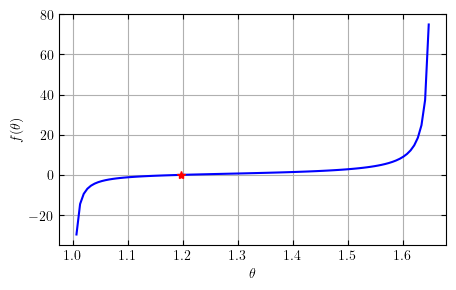

R_min = 2.265
X = 0.184
Y = 0.475
N = 22.461


In [170]:
def f(x,q):
    ff = -1+q
    for i in range(np.size(aij)):
        ff += aij[i]*xF[i]/(aij[i]-x)
    return ff

def R_min(theta):
    R = -1
    for i in range(np.size(aij)):
        R += aij[i]*xD[i]/(aij[i]-theta)
    return R


sol = root_scalar(lambda x: f(x,q),x0=(aij[LK]+aij[HK])/2)
theta = sol.root
print(theta)

xx = np.linspace(1,aij[LK],100)

font = {'family' : 'serif',
         'size'   : 12,
         'serif':  'cmr10'
         }

plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "cmr10",
})

fig, ax = plt.subplots()
plt.plot(xx,f(xx,q),color='b')
plt.plot(theta,f(theta,q),marker='*',color='r')
plt.xlabel('$\\theta$')
plt.ylabel('$f(\\theta)$')
plt.tick_params(direction='in',top='true',bottom='true',left='true',right='true')
plt.grid()

plt.show()

fig.savefig('CHEN_3100_HW_11_1.png',dpi=300,bbox_inches='tight')


R_m = R_min(theta)

print('R_min = %0.3f' % R_m)


R = 3
X = (R-R_m)/(R+1)

print('X = %0.3f' % X)

Y = 1 - np.exp(((1+54.4*X)/(11+117.2*X))*(X-1)*X**-0.5)
print('Y = %0.3f' % Y)

N = (Y+N_min)/(1-Y)

print('N = %0.3f' % N)

In [171]:
NR_NS = ((xF[HK]/xF[LK])*(xB[LK]/xD[HK])**2*(B/D))**0.206

NS = (N-1)/(NR_NS+1)
NR = N - NS - 1
print('NR/NS = %0.3f' % NR_NS)
print('NS = %0.3f' % NS) 
print('NR = %0.3f' % NR) 

NR/NS = 0.844
NS = 11.636
NR = 9.826


# SRK VLE

In [174]:
N = np.size(x)

# Set up objective function for non-ideal system
T = dew_pt_T
y = xD
# Initial guess vector
x0 = np.zeros(N+1)
x0[0:N] = x
x0[-1] = T
# Predict non-ideal compositions using SRK EOS
sol = fsolve(obj_func_dew,x0=x0,args=(y,P,w,Tc,Pc,Rg))
x = sol[0:N]
T = sol[-1]
K = y/x
a_ij_D = K/K[HK]

print('\n')
print('-------------------- DISTILLATE --------------------')
print('SRK Predicted Distillate VLE')
print('x = ')
print(x)
print('K = ')
print(K)
print('a_ij_D = ')
print(a_ij_D)
print('T = %0.3f' % T)


# Set up objective function for non-ideal system
T = bub_pt_T
# Initial guess vector
x0 = np.zeros(N+1)
x0[0:N] = y_id
x0[-1] = T
# Predict non-ideal compositions using SRK EOS
sol = fsolve(obj_func_bub,x0=x0,args=(xB,P,w,Tc,Pc,Rg))
y = sol[0:N]
T = sol[-1]
K = y/xB
a_ij_B = K/K[HK]

print('\n')
print('-------------------- BOTTOMS --------------------')
print('SRK Predicted Bottoms VLE')
print('y = ')
print(y)
print('K = ')
print(K)
print('a_ij_B = ')
print(a_ij_B)
print('T = %0.3f' % T)



-------------------- DISTILLATE --------------------
SRK Predicted Distillate VLE
x = 
[9.36676602e-01 6.32701709e-02 5.31086363e-05 1.17851296e-07]
K = 
[1.0244503  0.63858387 0.33968524 0.18464719]
a_ij_D = 
[1.60425333 1.         0.5319352  0.28915103]
T = 339.060


-------------------- BOTTOMS --------------------
SRK Predicted Bottoms VLE
y = 
[0.06908519 0.50537596 0.2006315  0.22490735]
K = 
[3.23776799 1.8897691  0.94031936 0.45173903]
a_ij_B = 
[1.71331407 1.         0.49758426 0.23904456]
T = 368.512


In [175]:
aij = np.sqrt(a_ij_B*a_ij_D)
q = 1.1
# Feed flows
f = F*xF

N_min = np.log((d[LK]/d[HK])*(b[HK]/b[LK]))/np.log(aij[LK])

for i in range(np.size(d)):
    if i < LK:
        b[i] = f[i]/(1+(d[HK]/b[HK])*aij[i]**N_min)
        d[i] = f[i] - b[i]
    elif i > HK:
        d[i] = (f[i]*(d[HK]/b[HK])*aij[i]**N_min)/(1+(d[HK]/b[HK])*aij[i]**N_min)
        b[i] = f[i] - d[i]


print('a_ij = ')
print(aij)     
        
        
print('\nN_min = %0.3f' % N_min)
print('\nf =')
print(f)
print('\nd =')
print(d)
print('\nb =')
print(b)

D = np.sum(d)
B = np.sum(b)

xD = d/D
xB = b/B

print('\nxD =')
print(xD)
print('\nxB =')
print(xB)
print('\nD = %0.3f' % D)
print('B = %0.3f' % B)


a_ij = 
[1.65788715 1.         0.51447312 0.2629068 ]

N_min = 11.267

f =
[30. 20. 15. 35.]

d =
[2.85000000e+01 1.20000000e+00 5.35817289e-04 6.48614726e-07]

b =
[ 1.5        18.8        14.99946418 34.99999935]

xD =
[9.59578627e-01 4.04033106e-02 1.80406603e-05 2.18384852e-08]

xB =
[0.02133729 0.26742736 0.21336527 0.49787008]

D = 29.701
B = 70.299


1.2032394474270898


C:\Users\pheng\AppData\Local\Temp\ipykernel_32812\1809642018.py:31: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()
C:\Users\pheng\AppData\Local\Temp\ipykernel_32812\1809642018.py:4: RuntimeWarning: divide by zero encountered in divide
  ff += aij[i]*xF[i]/(aij[i]-x)


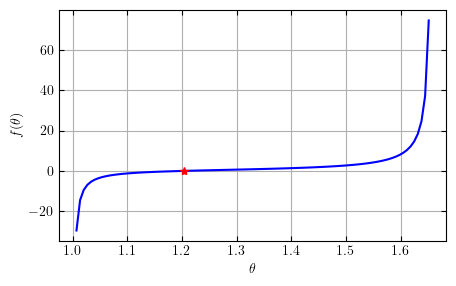

R_min = 2.300
X = 0.175
Y = 0.482
N = 22.700


In [176]:
def f(x,q):
    ff = -1+q
    for i in range(np.size(aij)):
        ff += aij[i]*xF[i]/(aij[i]-x)
    return ff

def R_min(theta):
    R = -1
    for i in range(np.size(aij)):
        R += aij[i]*xD[i]/(aij[i]-theta)
    return R

sol = root_scalar(lambda x: f(x,q),x0=(aij[LK]+aij[HK])/2)
theta = sol.root
print(theta)

xx = np.linspace(1,aij[LK],100)

font = {'family' : 'serif',
         'size'   : 12,
         'serif':  'cmr10'
         }

plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "cmr10",
})

fig, ax = plt.subplots()
plt.plot(xx,f(xx,q),color='b')
plt.plot(theta,f(theta,q),marker='*',color='r')
plt.xlabel('$\\theta$')
plt.ylabel('$f(\\theta)$')
plt.tick_params(direction='in',top='true',bottom='true',left='true',right='true')
plt.grid()

plt.show()

fig.savefig('CHEN_3100_HW_11_2.png',dpi=300,bbox_inches='tight')


R_m = R_min(theta)

print('R_min = %0.3f' % R_m)


R = 3
X = (R-R_m)/(R+1)

print('X = %0.3f' % X)

Y = 1 - np.exp(((1+54.4*X)/(11+117.2*X))*(X-1)*X**-0.5)
print('Y = %0.3f' % Y)

N = (Y+N_min)/(1-Y)

print('N = %0.3f' % N)

In [177]:
NR_NS = ((xF[HK]/xF[LK])*(xB[LK]/xD[HK])**2*(B/D))**0.206

NS = (N-1)/(NR_NS+1)
NR = N - NS - 1
print('NR/NS = %0.3f' % NR_NS)
print('NS = %0.3f' % NS) 
print('NR = %0.3f' % NR) 

NR/NS = 0.844
NS = 11.765
NR = 9.935
